In [2]:
# -*- coding: utf-8 -*-
"""
@author: Etienne Kras
"""
# imports 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
import contextily as ctx
import xarray as xr

import geojson
import random
import itertools
import time
import rasterio
import ee
ee.Initialize()

from tqdm.notebook import tqdm_notebook
from mpl_toolkits.axes_grid1 import make_axes_locatable
from osgeo import gdal, osr
from sklearn.neighbors import KDTree
from shapely.geometry import Polygon, LineString
from scipy.optimize import minimize
from google.cloud import storage
from operator import itemgetter

%matplotlib widget

# Project specific toggles

In [3]:
# acknowledgements & code references:
# https://github.com/openearth/eo-bathymetry/
# https://github.com/openearth/eo-bathymetry-functions/
# https://github.com/gee-community/ee-packages-py

# inspiration
# JIP CALM KRAS SDB WORKFLOW

In [4]:
# project toggles
main_fol = r"p:/11208561-he11-abu-dhabi/6_satellite_bathymetry" # name of the main local folder 
data_fol = r"p:/11208561-he11-abu-dhabi/1_data/" # data folder
bucket = 'hudayriat-sdb' # name of the Google Cloud Storage bucket to store files in the cloud
credential_file = r"Z:/OneDrive - Stichting Deltares/Documents/3. General/keys/jip-calm-0162576b9743.json" # Cloud Storage credential key
input_fol = "Proxy" # name of the input folder
output_fol = "SDB" # name of the output folder
project_name = 'Hudayriat' # name of the project AoI

# composite image toggles 
scale = 10  # input resolution of the image [m]
zoom_level = "" # zoom level or leave empty in case of an arbitrary polygons 

# load google credentials, if specified
if not credential_file == "":  
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(credential_file)

# Loading pre-processed files (API)

In [8]:
# DIRECTLY FROM THE CLOUD

# get file names
client = storage.Client()
ls = [blob for blob in client.list_blobs(bucket)] 
            
# get data from Google Cloud Storage
tiles = []
tile_paths = []
tile_names = []
tile_times = []

for blob in tqdm_notebook(ls):
    #if "tif" in blob.name:
    mode_fol = blob.name.split('/')[0]
    
    # condition to specify tiling or arbitrary polygons
    if zoom_level == "": cond = "t" # total polygon starts with timesteps directly
    if zoom_level != "": cond = zoom_level

    if mode_fol == "subtidal" and "2021" in blob.name.split('/')[-1] and cond in blob.name.split('/')[1]: # TODO: incorporate "2021" in project toggles as start_date...
        print(mode_fol, blob.name)
        with rasterio.Env(GS_ACCESS_KEY_ID=credential_file):
            tiles.append(gdal.Open(r"https://storage.googleapis.com/{}/{}".format(bucket, blob.name)))
            tile_paths.append(r"https://storage.googleapis.com/{}/{}".format(bucket, blob.name))
            tile_names.append(("_").join(blob.name.split("/")[1:]))
            tile_times.append(blob.name.split('/t')[-1].split('.')[0].split('_')[-2] + ' - ' + blob.name.split('/t')[-1].split('.')[0].split('_')[-1])
            time.sleep(0.01)

  0%|          | 0/56 [00:00<?, ?it/s]

subtidal subtidal/t2021-01-01_2022-01-01.tif t2021-01-01_2022-01-01.tif


In [5]:
# DIRECTLY FROM THE LOCAL DRIVE

# get data from local drive
tiles = []
tile_paths = []
tile_names = []
tile_times = []
for file in tqdm_notebook(os.listdir(os.path.join(main_fol, input_fol, "subtidal"))):

    # condition to specify tiling or arbitrary polygons
    if zoom_level == "": cond = "t" # total polygon starts with timesteps directly
    if zoom_level != "": cond = zoom_level  
    
    if 'xml' not in file and '2021' in file and cond in file.split("_")[0]: # TODO: make filter nicer
        print(file)
        tiles.append(gdal.Open(os.path.join(main_fol, input_fol, "subtidal", file)))
        tile_paths.append(os.path.join(main_fol, input_fol, "subtidal", file))
        tile_names.append(file)
        tile_times.append(file.split('.')[0].split('t')[-1].split('_')[-2] + ' - ' + file.split('.')[0].split('t')[-1].split('_')[-1])
        time.sleep(0.01)

  0%|          | 0/28 [00:00<?, ?it/s]

t2021-01-01_2022-01-01.tif


# Post-processing

In [6]:
# TODO: calibration with ICESat-2 data iso in-situ data?
# TODO: clean code

In [7]:
# open AoI
with open(os.path.join(main_fol, "AOI", project_name + ".geojson"), 'r') as f:
    contents = geojson.loads(f.read())
AoI = LineString(contents["features"][0]["geometry"]["coordinates"])
gdf_aoi = gpd.GeoDataFrame(geometry=[Polygon(AoI)], crs="epsg:4326")

In [8]:
# open bathy file
#check_file = pd.read_table(os.path.join(data_fol, r"DO_NOT_USE_OR_DISTRIBUTE\Bayanat_survey_2013 (not complete)\corniche_DOT_wgs84geo.xyz"), delim_whitespace=True, names=['x', 'y', 'z']) # subset
#check_file = pd.read_table(os.path.join(data_fol, r"DO_NOT_USE_OR_DISTRIBUTE\Bayanat_survey_2013 (not complete)\ALL_UAE1007-1015_WGS84Geo.xyz"), delim_whitespace=True, names=['x', 'y', 'z']) # all points
check_file = pd.read_table(os.path.join(data_fol, r"1_from_Parsons/recd_20230324_Bathymetry survey\bathymetry_H_E11_geowgs_NADD.xyz"), delim_whitespace=True, names=['x', 'y', 'z']) # all points
gdf_is = gpd.GeoDataFrame(check_file, crs="epsg:4326", geometry=gpd.points_from_xy(check_file.x, check_file.y))

In [9]:
# filter in-situ data on AoI
gdf_is_fil = gpd.sjoin(gdf_is, gdf_aoi).reset_index()

# get rid of "out of water points"
gdf_is_fil2 = gdf_is_fil[gdf_is_fil.z < 0].reset_index()

# reproject the in-situ data
gdf_is_fil_tsp = gdf_is_fil2.to_crs("epsg:3857")

In [10]:
# TODO: mask layer with ldb or with layer itself (as possible with water mask from SDB subtidal)
# open LDB file
with open(os.path.join(data_fol, r"2_inhouse/DO_NOT_USE_OR_DISTRIBUTE\Bayanat_survey_2013 (not complete)\ag_wgs84geo_Apr2021_v2a_closed.ldb")) as f:
    lines = f.read().splitlines()

# data preperation
ldb_pol = []
counter = -1
for idx, i in enumerate(lines[5:]): # skip the header
    if i == "*": continue
    if i.startswith("L"): # marks a line, create a sublist and add to counter
        ldb_pol.append([]) # make sublist
        counter += 1 # identify index of created sublist
        linfo = idx+1 # identify index of information on coordinates in line element
    if idx != linfo and not i.startswith("L"): # only append line coords
        ldb_pol[counter].append([float(j) for j in i.lstrip().split("   ")])

# make geodataframe
#ldb_pols = [Polygon(i) for i in ldb_pol]
ldb_pols = []
for idx, i in enumerate(ldb_pol):
    if Polygon(i).area > 5: # make the large polygon an outer polygon (arbitrary value)
        ls = i[0:-2] # get rid of last duplicate point

        # add 4 points to make the outer polygon land area (note now added good order manually)
        ls_unz = list(zip(*ls))
        ll = [np.min(ls_unz[0]), np.min(ls_unz[1])] 
        ur = [np.max(ls_unz[0]), np.max(ls_unz[1])] 
        ul = [np.min(ls_unz[0]), np.max(ls_unz[1])]
        lr = [np.max(ls_unz[0]), np.min(ls_unz[1])] 
        ls.append(lr), ls.append(ll), ls.append(ul), ls.append(ur) 
        ldb_pols.append(Polygon(ls))
    else:
        ldb_pols.append(Polygon(i))
gdf_ldb = gpd.GeoDataFrame(geometry=ldb_pols, crs="epsg:4326")

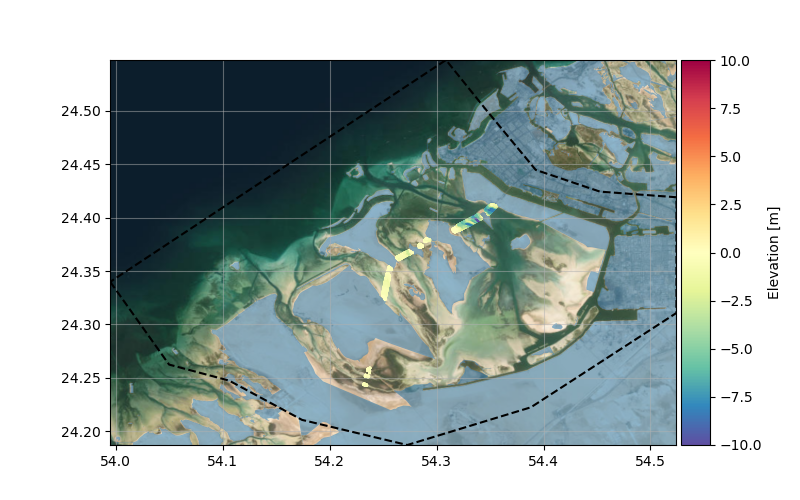

In [11]:
# make plot of in-situ data
fig, ax = plt.subplots(figsize=(8,5))
ax.grid(alpha=0.5)
ax.plot(AoI.xy[0], AoI.xy[1], 'k--')
gdf_ldb.plot(ax=ax, alpha=0.5)
plot = plt.scatter(gdf_is_fil2.x, gdf_is_fil2.y, s= 1, c = gdf_is_fil2.z, cmap='Spectral_r', vmin=-10, vmax=10) # might need to multiply z with -1 to invert depth

#ax.legend()

# colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = fig.colorbar(plot, shrink=.5, cax=cax)
cb.set_label('Elevation [m]')

# set zoom limits
ax.set_xlim(min(AoI.xy[0]), max(AoI.xy[0]))
ax.set_ylim(min(AoI.xy[1]), max(AoI.xy[1]))

# add imagery basemap
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs="epsg:4326", attribution="")

In [12]:
# define load function for tiff images
def LoadTiff(boxName,tiffName,tiffPath, EPSG = None):
    img = dict()
    b = rasterio.open(os.path.join(tiffPath, boxName, tiffName))
    img['name'] = tiffName
    img['meta'] = b.meta
    img['bandNames'] = b.descriptions
    img['data'] = np.moveaxis(b.read(), [0], [2]) # number of sets to spot 2, the shape (length x width) is on spot 0 and 1
    
    width = img['meta']['width']
    height = img['meta']['height']
    gt = b.get_transform()
    img['gt'] = gt
    minx = gt[0]
    miny = gt[3] + width*gt[4] + height*gt[5] 
    maxx = gt[0] + width*gt[1] + height*gt[2]
    maxy = gt[3]
    img['xdata'] = np.linspace(minx+gt[1]/2, maxx-gt[1]/2, width) # make x array and centerize the pixels
    img['ydata'] = np.flip(np.linspace(miny+gt[1]/2, maxy-gt[1]/2, height)) # make y array and centerize the pixels
    img['Mgrid'] = np.meshgrid(img['xdata'],img['ydata'])
    img['xgridar'] = img['Mgrid'][0].flatten()
    img['ygridar'] = img['Mgrid'][1].flatten()
    img['bounds'] = [minx,maxx,miny,maxy]

    x_tsp, y_tsp = [], []
    if b.crs.to_string().split(":")[-1] != EPSG and EPSG is not None:
        SRC = osr.SpatialReference()
        SRC.ImportFromEPSG(int(b.crs.to_string().split(":")[-1]))
        DST = osr.SpatialReference()
        DST.ImportFromEPSG(int(EPSG))     # WGS84 / Pseudo-Mercator
        SRC_to_DST = osr.CoordinateTransformation(SRC, DST)
        for i, j in zip(img["ygridar"], img["xgridar"]):
            #if np.isnan(k) == False: # only include non-nan values
            x, y, z = SRC_to_DST.TransformPoint(i, j)
            x_tsp.append(x), y_tsp.append(y)
    img['xgridar_tsp'] = np.array(x_tsp)
    img['ygridar_tsp'] = np.array(y_tsp)
     
    # convert to xarray dataframe
    coords = {'x': img['xdata'], 'y': img['ydata'], 'bands': list(img['bandNames'])}
    img['tiffDF'] = xr.DataArray(img['data'], dims=('y','x','bands'), coords=coords)
    
    return img

In [13]:
# get the subtidal SDB data
images = []
for file in os.listdir(os.path.join(main_fol, input_fol, "subtidal")):
    
    # condition to specify tiling or arbitrary polygons
    if zoom_level == "": cond = "t" # total polygon starts with timesteps directly
    if zoom_level != "": cond = zoom_level  

    if 'xml' not in file and '2021' in file and cond in file.split("_")[0]: # TODO: make filter nicer
        print(file)
        images.append(LoadTiff('',file,os.path.join(main_fol, input_fol, "subtidal"), "3857")) # get the image data, also with projected coords

t2021-01-01_2022-01-01.tif


In [14]:
# regression tree to find closest coordinates in the SDB image with relation to the in-situ data points (only perform once, takes a while)

# randomly select indexes from measured bathymetry
# gdf_is_fil_tsp_samp = gdf_is_fil_tsp.sample(n=1000, random_state=1).reset_index(drop=True) # random state = 1 to ensure repeatability
# val_data = list(zip([x.xy[0][0] for x in gdf_is_fil_tsp_samp.geometry], [x.xy[1][0] for x in gdf_is_fil_tsp_samp.geometry]))
val_data = list(zip(gdf_is_fil_tsp.geometry.centroid.x, gdf_is_fil_tsp.geometry.centroid.y))

# loop over images
SDBS_vals_r_red, SDBS_vals_g_red, SDBS_vals_b_red = [],[],[]
SDBS_xls_red, SDBS_yls_red, is_vals_red, is_xls_red, is_yls_red = [],[],[],[],[]
for idx, img in enumerate(images):
    print(idx)
    imagepoints = np.array(list(zip(img["xgridar_tsp"], img["ygridar_tsp"]))) # flat grid points of images 

    # TODO: spin up by doing this for only in-situ points in the same window of the image (sjoin)
    # build the tree (ndist and nind are equal to the length of randomly selected in-situ data)
    tree = KDTree(imagepoints)
    ndist, nind = tree.query(val_data) # get closest distance and index of the images
    #ndists.append(ndist), ninds.append(nind)

    # get the sorted unique values, the first occurence idx, the indices the values match and the number of matches
    nind_val, nind_idx, nind_inv, nind_cnt = np.unique(nind.flatten(), return_index=True, return_inverse=True, return_counts=True)

    # iterate through the list of data to see which connections are made against what distances / points
    distl = [[] for i in range(len(img["xgridar_tsp"]))]
    is_idx = [[] for i in range(len(img["xgridar_tsp"]))]
    dupl_im_idx = [[] for i in range(len(img["xgridar_tsp"]))]
    for idx, (i,j) in enumerate(zip(ndist.flatten(), nind_inv)):
        distl[j].append(i)
        is_idx[j].append(idx)
        dupl_im_idx[j].append(nind_val[j])

    # create reduced lists
    is_idx_new = [] # in-situ data matches idx
    im_idx_new = [] # image data idx
    distl_new = [] # distances between matches points
    for i, j, k in zip(dupl_im_idx, is_idx, distl):
        if len(i) > 0 and np.min(k) < (scale /2): # cap on half the scale to not include points far away
            is_idx_new.append(j[np.argmin(k)]) 
            im_idx_new.append(i[0])
            distl_new.append(np.min(k))

    if len(distl_new) > 0: # check whether there are matches

        if len(im_idx_new) > 1:

            # mask based on water band
            watermask = img["data"][:,:,3] < 0.0
            
            # image values
            SDBS_val_r = list(itemgetter(*list(im_idx_new))(np.ma.masked_array(img["data"][:,:,0], mask=watermask).flatten()))
            SDBS_val_g = list(itemgetter(*list(im_idx_new))(np.ma.masked_array(img["data"][:,:,1], mask=watermask).flatten()))
            SDBS_val_b = list(itemgetter(*list(im_idx_new))(np.ma.masked_array(img["data"][:,:,2], mask=watermask).flatten()))
            SDB_xl = list(itemgetter(*list(im_idx_new))(img["xgridar"]))
            SDB_yl = list(itemgetter(*list(im_idx_new))(img["ygridar"]))

            # in-situ values
            is_val = list(itemgetter(*list(is_idx_new))(gdf_is_fil_tsp.z))
            is_xl = list(itemgetter(*list(is_idx_new))(gdf_is_fil_tsp.x))
            is_yl = list(itemgetter(*list(is_idx_new))(gdf_is_fil_tsp.y))

        # get rid of Z values that include NaN (in one of the bands)
        SDBS_val_r_red = [a for a,b,c in zip(SDBS_val_r,SDBS_val_g,SDBS_val_b) if (np.isnan(a) == False and np.isnan(b) == False and np.isnan(c) == False)]
        SDBS_val_g_red = [b for a,b,c in zip(SDBS_val_r,SDBS_val_g,SDBS_val_b) if (np.isnan(a) == False and np.isnan(b) == False and np.isnan(c) == False)]
        SDBS_val_b_red = [c for a,b,c in zip(SDBS_val_r,SDBS_val_g,SDBS_val_b) if (np.isnan(a) == False and np.isnan(b) == False and np.isnan(c) == False)]
        SDBS_val_red_idx = [idx for idx, (a,b,c) in enumerate(zip(SDBS_val_r,SDBS_val_g,SDBS_val_b)) if (np.isnan(a) == False and np.isnan(b) == False and np.isnan(c) == False)]

        # reduce other lists with NaN
        SDB_xl_red = np.array(SDB_xl)[SDBS_val_red_idx] 
        SDB_yl_red = np.array(SDB_yl)[SDBS_val_red_idx]  
        is_val_red = np.array(is_val)[SDBS_val_red_idx] 
        is_xl_red = np.array(is_xl)[SDBS_val_red_idx] 
        is_yl_red = np.array(is_yl)[SDBS_val_red_idx]  

        # appending
        SDBS_vals_r_red.append(np.array(SDBS_val_r_red)), SDBS_vals_g_red.append(np.array(SDBS_val_g_red)), SDBS_vals_b_red.append(np.array(SDBS_val_b_red))
        SDBS_xls_red.append(np.array(SDB_xl_red)), SDBS_yls_red.append(np.array(SDB_yl_red))
        is_vals_red.append(np.array(is_val_red)), is_xls_red.append(np.array(is_xl_red)), is_yls_red.append(np.array(is_yl_red))
    
    else: # append empty
        SDBS_vals_r_red.append(np.array([])), SDBS_vals_g_red.append(np.array([])), SDBS_vals_b_red.append(np.array([]))
        SDBS_xls_red.append(np.array([])), SDBS_yls_red.append(np.array([]))
        is_vals_red.append(np.array([])), is_xls_red.append(np.array([])), is_yls_red.append(np.array([]))

0


In [15]:
# merging data into one list, while selecting only a number of points
# TODO: do with dataframe.. easier..

# merging all data
SDBS_vals_r_reds = list(itertools.chain(*SDBS_vals_r_red))
SDBS_vals_g_reds = list(itertools.chain(*SDBS_vals_g_red))
SDBS_vals_b_reds = list(itertools.chain(*SDBS_vals_b_red))
SDBS_xls_reds = list(itertools.chain(*SDBS_xls_red))
SDBS_yls_reds = list(itertools.chain(*SDBS_yls_red))
is_vals_reds = list(itertools.chain(*is_vals_red)) 
is_xls_reds = list(itertools.chain(*is_xls_red))
is_yls_reds = list(itertools.chain(*is_yls_red))

# select random of points
random.seed(5)
random_indexes = random.sample([idx for idx, i in enumerate(SDBS_vals_r_reds)], k=5000)

# reduce lists
SDBS_vals_r_reds_sel = np.array(SDBS_vals_r_reds)[random_indexes]
SDBS_vals_g_reds_sel = np.array(SDBS_vals_g_reds)[random_indexes]
SDBS_vals_b_reds_sel = np.array(SDBS_vals_b_reds)[random_indexes]
SDBS_xls_reds_sel = np.array(SDBS_xls_reds)[random_indexes]
SDBS_yls_reds_sel = np.array(SDBS_yls_reds)[random_indexes]
is_vals_reds_sel = np.array(is_vals_reds)[random_indexes]
is_xls_reds_sel = np.array(is_xls_reds)[random_indexes]
is_yls_reds_sel = np.array(is_yls_reds)[random_indexes]

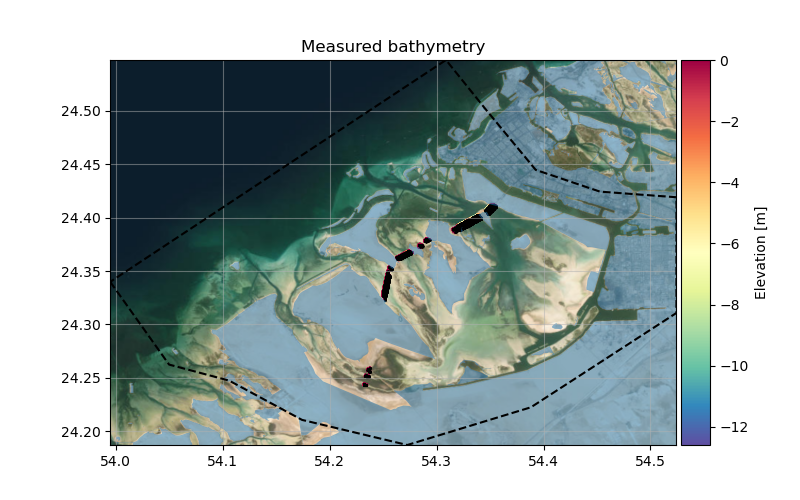

In [16]:
# show overview image
fig, ax = plt.subplots(figsize = (8,5))
plt.title('Measured bathymetry')
ax.plot(AoI.xy[0], AoI.xy[1], 'k--')
ax.grid(alpha=0.5)
data = plt.scatter(gdf_is_fil2.x, gdf_is_fil2.y, s= 1, c = gdf_is_fil2.z, cmap='Spectral_r', vmin=np.min(gdf_is_fil2.z), vmax=0) 
plot = plt.scatter(is_xls_reds_sel, is_yls_reds_sel, s= 1, c = 'k') # note the -1 to invert the depth
gdf_ldb.plot(ax=ax, alpha=0.5)
# deep = plt.imshow(Deep_MDB, cmap=matplotlib.colors.ListedColormap('black', name='colors'), alpha=0.8)

# colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = fig.colorbar(data, shrink=.5, cax=cax)
cb.set_label('Elevation [m]')

# set zoom limits
ax.set_xlim(min(AoI.xy[0]), max(AoI.xy[0]))
ax.set_ylim(min(AoI.xy[1]), max(AoI.xy[1]))

# add imagery basemap
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs="epsg:4326", attribution="")

In [17]:
# construct dataframe
SDBdata_spats = pd.DataFrame()
SDBdata_spats['x'] = is_xls_reds_sel
SDBdata_spats['y'] = is_yls_reds_sel
SDBdata_spats['z_obs'] = np.array(is_vals_reds_sel)#*-1 # correct for depth positive to depth negative
SDBdata_spats['z_sdb_b'] = SDBS_vals_b_reds_sel
SDBdata_spats['z_sdb_g'] = SDBS_vals_g_reds_sel
SDBdata_spats['z_sdb_r'] = SDBS_vals_r_reds_sel

# filter out certain areas for calibration (deep channels, .. etc)
thresh_deep = -8
SDBdata_spat = pd.DataFrame()
maskdeep = SDBdata_spats['z_obs'] > thresh_deep
SDBdata_spat['x'] = SDBdata_spats['x'][maskdeep]
SDBdata_spat['y'] = SDBdata_spats['y'][maskdeep]
SDBdata_spat['z_obs'] = SDBdata_spats['z_obs'][maskdeep]
SDBdata_spat['z_sdb_b'] = SDBdata_spats['z_sdb_b'][maskdeep]
SDBdata_spat['z_sdb_g'] = SDBdata_spats['z_sdb_g'][maskdeep]
SDBdata_spat['z_sdb_r'] = SDBdata_spats['z_sdb_r'][maskdeep]

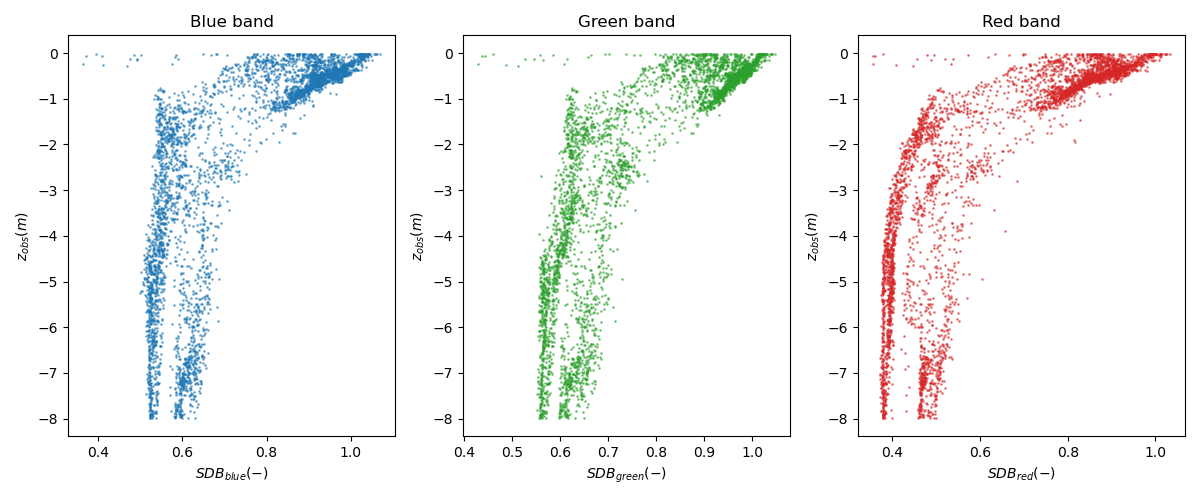

In [18]:
# show scatter plots
fig = plt.figure(figsize = (12, 5))
fig.add_subplot(131)
plt.scatter(SDBdata_spat['z_sdb_b'], SDBdata_spat['z_obs'], s = 1, color = 'C0', alpha = 0.5)
#plt.ylim(np.nanmin(SDBdata_spat['z_obs']),0)
#plt.xlim(np.nanmin(SDBdata_spat['z_sdb_b']), np.nanmax(SDBdata_spat['z_sdb_b']))
plt.title('Blue band')
plt.xlabel(r'$SDB_{blue} (-)$')
plt.ylabel(r'$z_{obs} (m)$')

fig.add_subplot(132)
plt.scatter(SDBdata_spat['z_sdb_g'], SDBdata_spat['z_obs'], s = 1, color = 'C2', alpha = 0.5)
#plt.ylim(np.nanmin(SDBdata_spat['z_obs']),0)
#plt.xlim(np.nanmin(SDBdata_spat['z_sdb_g']), np.nanmax(SDBdata_spat['z_sdb_g']))
plt.title('Green band')
plt.xlabel(r'$SDB_{green} (-)$')
plt.ylabel(r'$z_{obs} (m)$')

fig.add_subplot(133)
plt.scatter(SDBdata_spat['z_sdb_r'], SDBdata_spat['z_obs'], s = 1, color = 'C3', alpha = 0.5)
#plt.ylim(np.nanmin(SDBdata_spat['z_obs']),0)
#plt.xlim(np.nanmin(SDBdata_spat['z_sdb_r']), np.nanmax(SDBdata_spat['z_sdb_r']))
plt.title('Red band')
plt.xlabel(r'$SDB_{red} (-)$')
plt.ylabel(r'$z_{obs} (m)$')

plt.tight_layout()

In [19]:
# TODO: calibrate smaller areas (i.e. multiple calibration algorithms per sub-area that somehow overlap in eachother; hybrid calibration (SVM))
# linear regression definitions (log-linear based)
from sklearn import metrics

# root mean square error
def RMSE_LinRegression_spat(beta):
    global SDBdata_spat
    b0, b1, b2, b3 = beta
    
    d_sdb = b0 + b1*SDBdata_spat.z_sdb_r + b2*SDBdata_spat.z_sdb_g + b3*SDBdata_spat.z_sdb_b
    d_msb = SDBdata_spat.z_obs
    
    d_sdbnew = [i for idx, i in enumerate(d_sdb) if np.isnan(i) == False]
    d_sdbnewidx = [idx for idx, i in enumerate(d_sdb) if np.isnan(i) == False]
    d_msbnew = [d_msb.values[i] for i in d_sdbnewidx]
    
    return metrics.mean_squared_error(d_msbnew, d_sdbnew, squared=False)

# linear regression
def LinRegression_spat(beta):
    global SDBdata_spat
    b0, b1, b2, b3 = beta
    
    d_sdb = b0 + b1*SDBdata_spat.z_sdb_r.values + b2*SDBdata_spat.z_sdb_g.values + b3*SDBdata_spat.z_sdb_b.values
    d_msb = SDBdata_spat.z_obs
    
    # show calibration image
    plt.figure(figsize = (6,6))
    plt.title('Calibration of transect data')
    plt.plot(d_sdb, color='m', label='lin regress SDB')
    plt.grid(alpha=0.5)
    plt.plot(d_msb.values, color='C0', label='bathymetry')
    plt.xlim(0,len(d_msb.index))
    plt.fill_between(np.linspace(0,len(d_msb.index),len(d_msb.index)),0,np.nanmin(d_msb),color='k',alpha=0.3, label='bathymetry range')
    plt.ylabel('Z [m]')
    plt.xlabel('number of points [-]')
    plt.legend()
        
    return pd.DataFrame(data = d_sdb, columns = ['sdb'])

In [20]:
# TODO: continue this line by trying other fits like in RWS Bathymetry https://www.openearth.nl/rws-bathymetry/2018.html
# beyond linear regression

# function to find r2 while polyfitting
def adjR(x, y, degree):
    coeffs = np.polyfit(x, y, degree)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    #r2_test = metrics.r2_score(y, yhat)
    r2 = 1- (((1-(ssreg/sstot))*(len(y)-1))/(len(y)-degree-1))
    return r2#, r2_test

      6             5             4             3             2
9057 x - 4.142e+04 x + 7.873e+04 x - 7.972e+04 x + 4.534e+04 x - 1.371e+04 x + 1710 r2: 0.726751431424823
       4        3        2
845.4 x - 2674 x + 3096 x - 1540 x + 272.1 0.725631321865271
r2:  0.725631321865271
RMSE:  1.2806587006965506


C:\Users\kras\AppData\Local\Temp\ipykernel_11136\824605676.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6,5))


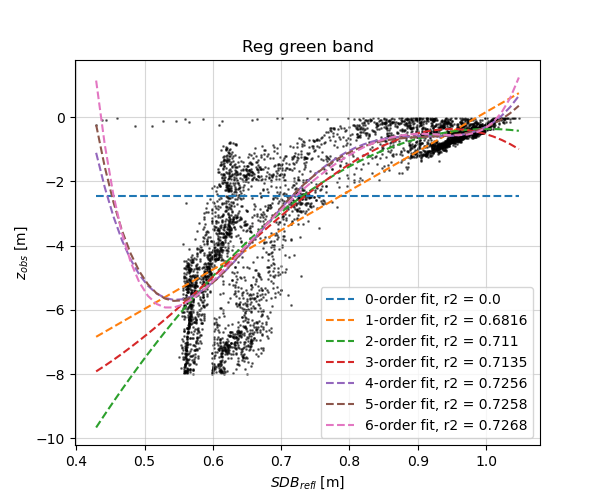

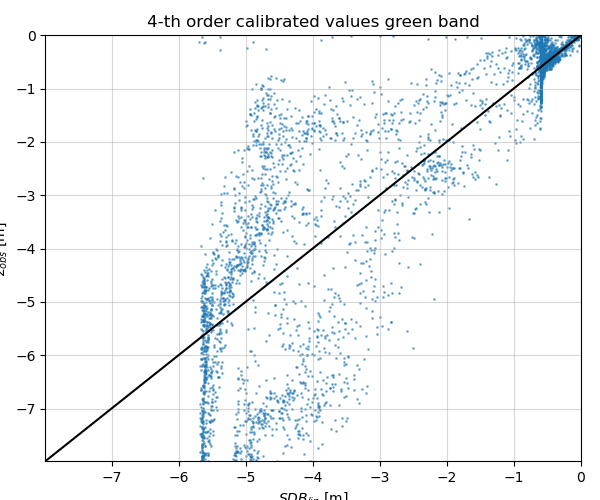

In [28]:
# retrieve R2 values
rlist = []
for i in range(7): # fit up to fifth degree polynomial
    rlist.append(adjR(SDBdata_spat['z_sdb_g'], SDBdata_spat['z_obs'], i)) # turn around 
rlist_c = [np.nan if round(i,3) == 1 or i == np.inf else i for i in rlist] # replace r2 equal 1 and inf (overfitted) with nan
spl = np.poly1d(np.polyfit(SDBdata_spat['z_sdb_g'], SDBdata_spat['z_obs'], np.nanargmax(rlist_c)))
spls = [np.poly1d(np.polyfit(SDBdata_spat['z_sdb_g'], SDBdata_spat['z_obs'], x)) for x in range(7)]
rnd_vls = np.linspace(np.nanmin(SDBdata_spat['z_sdb_g']), np.nanmax(SDBdata_spat['z_sdb_g']), 50)
print(spl, 'r2:', np.nanmax(rlist_c))
print(spls[4], rlist_c[4])
sel_fit = 4

# TODO: make elbow function to select best order fit based on increase of correlation vs increase of order of fit.

# make figure
plt.figure(figsize=(6,5))
plt.title(r'Reg green band')
plt.scatter(SDBdata_spat['z_sdb_g'], SDBdata_spat['z_obs'], s=1, c='k', alpha=0.5)
for idx,i in enumerate(rlist_c):
    plt.plot(rnd_vls, spls[idx](rnd_vls), '--', label='%s-order fit, r2 = %s'%(idx,round(i,4)))
plt.legend()
plt.grid(alpha=0.5)
plt.ylabel(r'$z_{obs}$ [m]')
plt.xlabel(r'$SDB_{refl}$ [m]')

plt.figure(figsize=(6,5))
plt.title(r'%s-th order calibrated values green band'%sel_fit)
plt.scatter(spls[sel_fit](SDBdata_spat['z_sdb_g']), SDBdata_spat['z_obs'], s = 1, alpha = 0.5)
plt.plot([round(np.min(SDBdata_spat.z_obs),0),0], [round(np.min(SDBdata_spat.z_obs),0),0], 'k') # lin regress

# update dataset with linear calibration
plt.xlim(np.min(SDBdata_spat.z_obs), 0)
plt.ylim(np.min(SDBdata_spat.z_obs), 0)
plt.grid(alpha = 0.5)
plt.tight_layout()

plt.ylabel(r'$z_{obs}$ [m]')
plt.xlabel(r'$SDB_{lin}$ [m]')

# compute RMSE & r2
print("r2: ", rlist_c[sel_fit])
print('RMSE: ', metrics.mean_squared_error(SDBdata_spat['z_obs'], spls[sel_fit](SDBdata_spat['z_sdb_g']), squared=False))

Optimization terminated successfully.
         Current function value: 1.029998
         Iterations: 15
         Function evaluations: 669
r2:  0.8226798581209293
RMSE:  1.0299982650794512


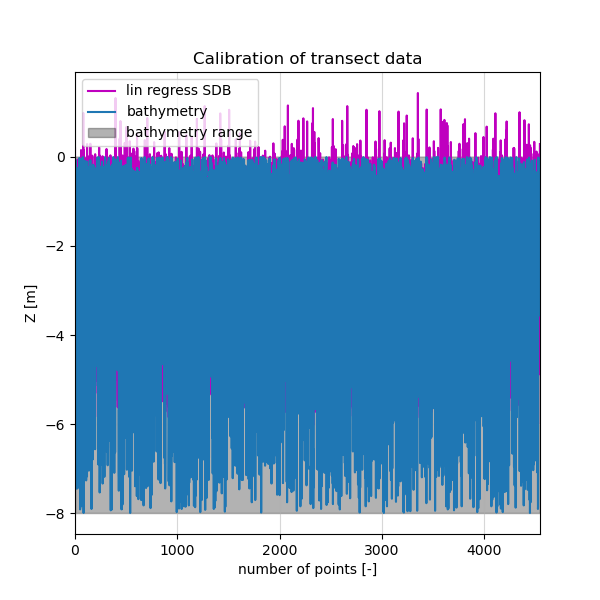

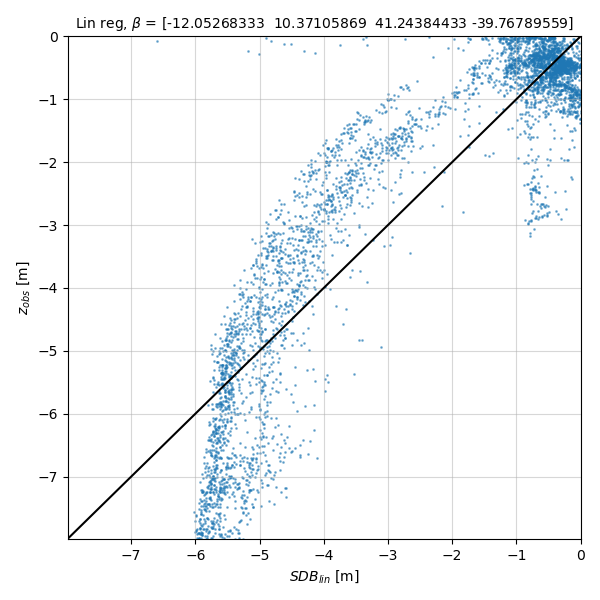

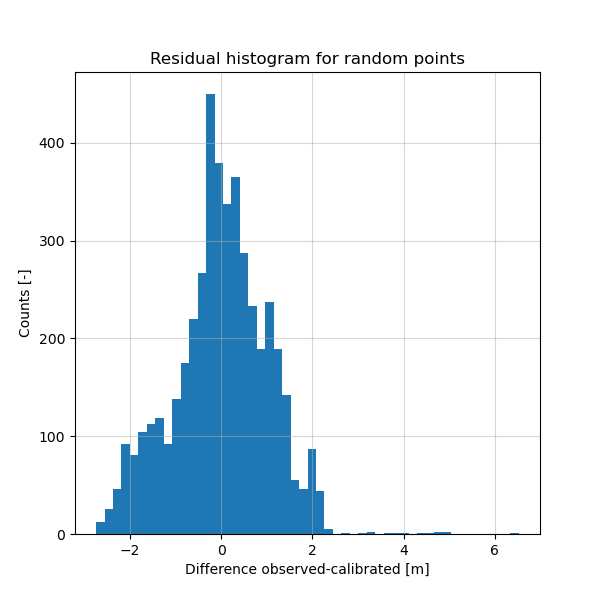

In [25]:
# TODO: masking out certain areas, like below:
# TODO: improve by masking away the 'above LAT' points (i.e. intertidal regime)
# TODO: improve by masking away the sea grass patches (different bottom albedo)
# TODO: test different methods to calibrate
# TODO: fusing intertidal and subtidal elevations? Inspiration??

# determine smallest residual error
method_spat = 'Powell'
if method_spat == 'COBYLA':
    res_spat = minimize(RMSE_LinRegression_spat, [0.,0.,0.,0.] , method=method_spat,options={'tol': 1e-6, 'disp': True}) 
else:
    res_spat = minimize(RMSE_LinRegression_spat, [0.,0.,0.,0.] , method=method_spat,options={'xtol': 1e-6, 'disp': True}) 

# calibrated linear regression 
Calibrated_Lin_spat = LinRegression_spat(res_spat.x)

print('r2: ', metrics.r2_score(SDBdata_spat.z_obs, Calibrated_Lin_spat['sdb']))

# # make figure
plt.figure(figsize = (6,6))
plt.title(r'Lin reg, $\beta$ = {}'.format(res_spat.x), fontsize = 10  )
plt.scatter(Calibrated_Lin_spat['sdb'], SDBdata_spat.z_obs, s = 1, alpha = 0.5)
plt.plot([round(np.min(SDBdata_spat.z_obs),0),0], [round(np.min(SDBdata_spat.z_obs),0),0], 'k') # lin regress

plt.ylabel(r'$z_{obs}$ [m]')
plt.xlabel(r'$SDB_{lin}$ [m]')

# update dataset with linear calibration
SDBdata_spat['LinCalibration'] = Calibrated_Lin_spat['sdb'].values
plt.xlim(np.min(SDBdata_spat.z_obs), 0)
plt.ylim(np.min(SDBdata_spat.z_obs), 0)
plt.grid(alpha = 0.5)
plt.tight_layout()

# residual histogram
plt.figure(figsize = (6,6))
plt.title('Residual histogram for random points')
plt.xlabel('Difference observed-calibrated [m]')
plt.ylabel('Counts [-]')
plt.grid(alpha = 0.5)
plt.hist(SDBdata_spat.z_obs - SDBdata_spat.LinCalibration, bins = 50)

# compute RMSE
print('RMSE: ', metrics.mean_squared_error(SDBdata_spat.z_obs, Calibrated_Lin_spat['sdb'], squared=False))

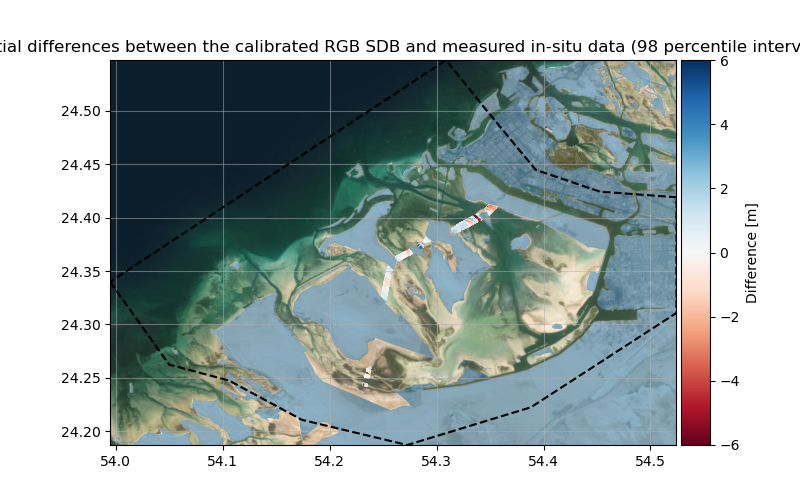

In [29]:
# plot all calibrated data

# construct calibrated SDB RGB image
b0, b1, b2, b3 = res_spat.x
cal_sdb_spat = b0 + b1*np.array(SDBS_vals_r_reds) + b2*np.array(SDBS_vals_g_reds) + b3*np.array(SDBS_vals_b_reds)

# mask deep areas
#cal_sdb_spat_d2 = copy.deepcopy(cal_sdb_spat)
#cal_sdb_spat_d2[MaskSDB] = np.nan

# difference measured and derived bathy
diffbathy_spat = np.array(is_vals_reds) - cal_sdb_spat

# show image
fig, ax = plt.subplots(figsize = (8,5))

# fig.add_subplot(311)
# plt.title('Calibrated RGB Satellite Derived Bathymetry (SDB)')
# plt.grid(alpha=0.5)
# ax.plot(AoI.xy[0], AoI.xy[1], 'k--')
# data = plt.scatter(SDBS_xls_reds, SDBS_yls_reds, s= 1, c = cal_sdb_spat, cmap='Spectral_r', vmin=np.min(cal_sdb_spat), vmax=0)
# gdf_ldb.plot(ax=ax, alpha=0.5)
# # deep = plt.imshow(Deep_MDB, cmap=matplotlib.colors.ListedColormap('black', name='colors'), alpha=0.8)

# # colorbar
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# cb = fig.colorbar(data, shrink=.5, cax=cax)
# cb.set_label('Elevation [m]')

# # set zoom limits
# ax.set_xlim(min(AoI.xy[0]), max(AoI.xy[0]))
# ax.set_ylim(min(AoI.xy[1]), max(AoI.xy[1]))

# # add imagery basemap
# ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs="epsg:4326", attribution="")

# fig.add_subplot(312)
# plt.title('Measured in-situ data')
# plt.grid(alpha=0.5)
# ax.plot(AoI.xy[0], AoI.xy[1], 'k--')
# data = plt.scatter(is_xls_reds, is_yls_reds, s= 1, c = is_vals_reds, cmap='Spectral_r', vmin=np.min(cal_sdb_spat), vmax=0)
# gdf_ldb.plot(ax=ax, alpha=0.5)
# # deep = plt.imshow(Deep_MDB, cmap=matplotlib.colors.ListedColormap('black', name='colors'), alpha=0.8)

# # colorbar
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# cb = fig.colorbar(data, shrink=.5, cax=cax)
# cb.set_label('Elevation [m]')

# # set zoom limits
# ax.set_xlim(min(AoI.xy[0]), max(AoI.xy[0]))
# ax.set_ylim(min(AoI.xy[1]), max(AoI.xy[1]))

# # add imagery basemap
# ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs="epsg:4326", attribution="")

# fig.add_subplot(313)
plt.title('Spatial differences between the calibrated RGB SDB and measured in-situ data (98 percentile interval)')
plt.grid(alpha=0.5)
max_ero_acc_diff = round(max(np.nanpercentile(diffbathy_spat,99), abs(np.nanpercentile(diffbathy_spat,1))),0)
ax.plot(AoI.xy[0], AoI.xy[1], 'k--')
data = plt.scatter(is_xls_reds, is_yls_reds, s= 1, c = diffbathy_spat, cmap='RdBu', vmin=-max_ero_acc_diff, vmax=+max_ero_acc_diff)
gdf_ldb.plot(ax=ax, alpha=0.5)
# deep = plt.imshow(Deep_MDB, cmap=matplotlib.colors.ListedColormap('black', name='colors'), alpha=0.8)

# colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = fig.colorbar(data, shrink=.5, cax=cax)
cb.set_label('Difference [m]')

# set zoom limits
ax.set_xlim(min(AoI.xy[0]), max(AoI.xy[0]))
ax.set_ylim(min(AoI.xy[1]), max(AoI.xy[1]))

# add imagery basemap
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs="epsg:4326", attribution="")

In [85]:
# Trained RMSE, total RMSE and upper and lower bounds for COBYLA - constrained minimization
print('RMSE:', round(metrics.mean_squared_error(SDBdata_spat.z_obs, Calibrated_Lin_spat['sdb'], squared=False),2))
print('Upper (99) / Lower (1) percentile: ', round(np.nanpercentile(diffbathy_spat,99),1), round(np.nanpercentile(diffbathy_spat,1),1)) 
print('Total RMSE:', round(metrics.mean_squared_error(np.array(is_vals_reds), cal_sdb_spat, squared=False),2))

RMSE: 1.03
Upper (99) / Lower (1) percentile:  2.1 -6.1
Total RMSE: 1.59


In [31]:
# TODO: enhance calibration (see options in other todo's)
# TODO: fix tile boundaries.. or detrending:         

# detrending and plotting (inspiration from JIP CALM 2DV tool)
        # masked = ~np.isnan(ds) & ~np.isnan(zgs)
        # result = stats.linregress(ds[masked], zgs[masked])
        # trend = result.intercept + result.slope*ds
        # detrended = [zgs[j]-trend[j] for j in range(0, len(ds))]
        # det_z.append(detrended)

In [86]:
# export to local drive 

# construct and save tiff locally
for idx, i in enumerate(images): 

    # reconstruct calibrated bathy
    b0, b1, b2, b3 = res_spat.x
    temp = b0 + b1*i["data"][:,:,0] + b2*i["data"][:,:,1] + b3*i["data"][:,:,2]

    # mask away land area (watermask)
    temp[np.where(i["data"][:,:,3] < 0.0)] = np.nan 

    # drive gdal operation
    driver = gdal.GetDriverByName("GTiff")
    WLtiff = driver.Create(os.path.join(main_fol, output_fol, "TIFF/subtidal", i["name"]),i["meta"]["width"],i["meta"]["height"],1,gdal.GDT_Float32 ,options=["COMPRESS=LZW"])
    WLtiff.SetGeoTransform(i["gt"])
    srs = (osr.SpatialReference())  # construct spatial reference
    srs.ImportFromEPSG(4326)  # get crs
    WLtiff.SetProjection(srs.ExportToWkt())  # set projects (crs) of the tiff
    WLtiff.GetRasterBand(1).WriteArray(temp)  # write binary NDWI to the first band of the tiff
    WLtiff.FlushCache()  # saves tiff to disk
    WLtiff = None  # closes the file

In [87]:
# export to local drive

# construct and save XYZ data locally
for idx, i in enumerate(images):
    print(idx)

    # reconstruct calibrated bathy
    b0, b1, b2, b3 = res_spat.x
    temp = b0 + b1*i["data"][:,:,0] + b2*i["data"][:,:,1] + b3*i["data"][:,:,2]

    # fix to replace "non-existent mask" to match nan values
    # temp = j.copy()
    # temp[np.where(temp < tide_inds[0])] = np.nan 
    # temp[np.where(temp > tide_inds[-1])] = np.nan

    # extent of tile
    ys, xs = i["meta"]["height"], i["meta"]["width"]
    ulx, xres, _, uly, _, yres = i["gt"]
    
    # construct the raster coords
    xdata = np.linspace(ulx+xres/2, ulx+xres*xs-xres/2, xs)
    ydata = np.flip(np.linspace(uly+yres*ys-yres/2, uly+yres/2, ys))
    xx, yy = np.meshgrid(xdata,ydata)

    # get rid of nan values and move to lists
    X = np.reshape(xx.flatten(), (len(xx.flatten()),1))
    Y = np.reshape(yy.flatten(), (len(yy.flatten()),1))
    Z = np.reshape(temp.flatten(), (len(temp.flatten()),1))
    xyz = np.concatenate((X, Y, Z), axis=1)
    xyz_nonan = xyz[~np.isnan(xyz).any(axis=1)]

    fmt = '% -2.9f', '% -2.9f', '% -2.9f'
    with open(os.path.join(main_fol, output_fol, "XYZ/subtidal", i["name"].replace(".tif","_EPSG4326.xyz")), 'w') as ascii:
        np.savetxt(ascii, xyz_nonan, fmt=fmt, delimiter=' ')

0
